In [1]:
import numpy as np
np.random.seed(123)
import jax.numpy as jnp
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
from skscopepe import ScopeSolver

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

Classification on imbalanced labels with focal loss
-----------

### Introduction
Focal Loss is a loss function introduced in 2017 by Lin et al. as a way to address the class imbalance problem in object detection tasks, specifically in the context of one-stage detectors like RetinaNet. The primary goal of focal Loss is to give more weight to hard, or misclassified, examples during training, thus enabling the model to focus on difficult samples and improve overall performance.

Some real applications of focal Loss are shown as follows:

- Object Detection: focal Loss has been extensively used in object detection tasks, especially with single-shot detectors like RetinaNet. By emphasizing the training of difficult examples, focal Loss helps improve the detection of small objects or objects in cluttered scenes, leading to enhanced accuracy;

- Medical Image Analysis: focal Loss has shown promise in medical image analysis tasks, including lesion detection, tumor segmentation, and disease classification. Class imbalance is often prevalent in medical datasets, and focal Loss helps address this issue by emphasizing difficult cases, leading to better performance in detecting and classifying abnormalities;

- Natural Language Processing (NLP): While focal Loss was initially designed for computer vision tasks, it has also been adapted for NLP applications. In tasks like text classification or sentiment analysis, where class imbalance can be present, focal Loss has been employed to improve the model's ability to handle imbalanced datasets and enhance the learning of minority classes.

In the usual binary classification task, the loss is usually defined w.r.t. the predicted probability $p=\frac{1}{1+\exp(-\beta^{\top}x)}$ as the following cross entropy
$$
\text{CrossEntropy}(p)=\left\{
\begin{aligned}
&-\log(p), &y=1 \\
&-\log(1-p), &y=0 \\
\end{aligned}
\right.
$$
However, in the setteing where positive and negative class are extremly imbalanced, an alternative is the following focal loss
$$
\text{FocalLoss}(p;\alpha,\gamma)=\left\{
\begin{aligned}
&-\alpha (1-p)^{\gamma}\log(p), &y=1 \\
&-(1-\alpha) p^{\gamma}\log(1-p), &y=0 \\
\end{aligned}
\right.
$$
where $0<\alpha<1$ and $\gamma\geq0$ are two user-chosen hyperparameters.

### Intuitive illustration
From the above formula, we see that focal Loss just adds a factor $(1-p)^{\gamma}$ (ignoring $\alpha$ now) to the standard cross entropy criterion:

- If $y=1$ while $p$ is close to $0$, indicating a hard and missclassified sample, the added factor $(1-p)^{\gamma}$ is large. Thus, this sample is allocated with larger weight and more attention will be paid to it;

- If $y=1$ and $p$ is close to $1$, indicating an easy and correctly classified sample, the added factor $(1-p)^{\gamma}$ is small and smaller weight is allocated to this sample;

- Similar properties apply for $y=0$.

That is, focal Loss can adaptively tune the contribution (weight) of samples according to their difficulty of classification.

The following figure visualize the effect of the choice of $\gamma$.

A large $\gamma$ results a sharp adapter while a small $\gamma$ will result a mild adapter.

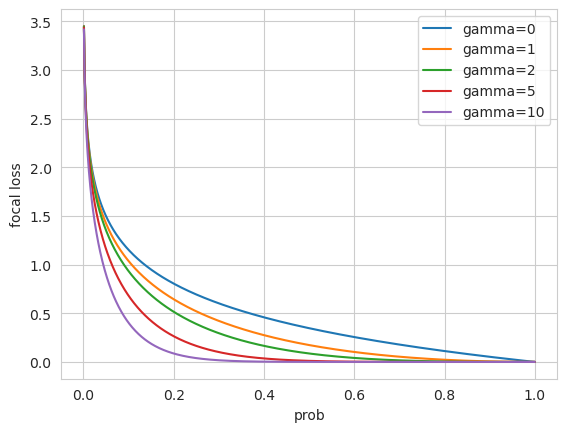

In [2]:
# visualize the focal loss
alpha = 0.5
gamma_list = [0, 1, 2, 5, 10]
x = np.linspace(0.001, 1, 1000)
for gamma in gamma_list:
    y = - alpha * (1 - x) ** gamma * np.log(x)
    plt.plot(x, y, label='gamma={}'.format(gamma))

plt.xlabel('prob')
plt.ylabel('focal loss')
plt.legend()
plt.show()

In this tutorial, we show how to perform a sparse imbalanced binary classification task using ``Focal Loss`` and ``scope``.

### Synthetic data example

We consider the binary classification problem with a dataset adapted from the breast cancer dataset. 

Instead of using the original dataset directly, we modify this dataset to an adapted one to illustrate the use of focal loss. Specifically,
- we first load the original data set using ``sklearn.datasets.load_breast_cancer``;
- then, we drop some samples in class $0$ to form a imbalanced dataset with imbalanced ration being $8.5$;
- lastly, we add some noise features to form a high-dimensional setting ($p$ is large). 


In [3]:
X, y = load_breast_cancer(return_X_y=True)
idx_drop = np.where(y==0)[0][:170]  
X, y = np.delete(X, idx_drop, axis=0), np.delete(y, idx_drop)  # drop some samples of class 0 to make an imbalanced dataset
X = (X - X.mean(0)) / X.std(0)  # standardize X 
rng = np.random.default_rng(seed=0)
Noise = rng.standard_normal((X.shape[0], 100-X.shape[1]))
X = np.hstack((X, Noise))  # append some noise features
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

print('X shape: ', X.shape)
print('Imbalanced ratio: ', np.round((y==1).sum() / (y==0).sum(), 3))

X shape:  (399, 100)
Imbalanced ratio:  8.5


In the following, we compare the results of ``scope`` using two different loss: cross entropy and focal loss.

The following code implements the cross entorpy loss using ``jnp.piecewise`` to define a piecewise function.

The result shows that the F1 score of the prediction induced by the cross entropy loss is $0.942$.

In [4]:
def cross_entropy(params):
    prob = 1 / (1 + jnp.exp(- X_train @ params))
    loss = jnp.mean(jnp.piecewise(prob, 
                                 [y_train==1, y_train==0], 
                                 [lambda x: -jnp.log(x), lambda x: -jnp.log(1-x)]
                    )
            )
    return loss

solver = ScopeSolver(dimensionality=X_train.shape[1], sparsity=8)
params = solver.solve(cross_entropy)

y_pred = ((1 / (1 + jnp.exp(- X_test @ params))) >= 0.5).astype(int)
print('F1 score of cross entropy: ', f1_score(y_test, y_pred).round(3))

F1 score of cross entropy:  0.942


Similarly, we implement the focal Loss with ``jnp.piecewise`` but a different scaling factor for adaptiveness.

The following code shows the F1 score of the prediction induced by the focal loss and we observe that result is improved in this imbalanced setting.

In [5]:
alpha, gamma = 0.5, 2
def focal_loss(params):
    prob = 1 / (1 + jnp.exp(- X_train @ params))
    loss = jnp.mean(jnp.piecewise(prob, 
                                 [y_train==1, y_train==0], 
                                 [lambda x: - alpha * (1-x)**gamma * jnp.log(x), lambda x: - (1-alpha) * x**gamma * jnp.log(1-x)]
                    )
            )
    return loss


solver = ScopeSolver(dimensionality=X_train.shape[1], sparsity=8)
params = solver.solve(focal_loss)

prob = 1 / (1 + jnp.exp(- X_test @ params))
y_pred = (prob >= 0.5).astype(int)
print('F1 score of focal loss: ', f1_score(y_test, y_pred).round(3))

F1 score of focal loss:  0.972


# Reference
- Lin T Y, Goyal P, Girshick R, et al. Focal loss for dense object detection[C]//Proceedings of the IEEE international conference on computer vision. 2017: 2980-2988.